In [1]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('dataset/synthetic_logs.csv')

df

,timestamp,source,log_message,target_label,complexity
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert
...,...,...,...,...,...
2405,2025-08-13 07:29:25,ModernHR,nova.osapi_compute.wsgi.server [req-96c3ec98-2...,HTTP Status,bert
2406,1/11/2025 5:32,ModernHR,User 3844 account experienced multiple failed ...,Security Alert,bert
2407,2025-08-03 03:07:47,ThirdPartyAPI,nova.metadata.wsgi.server [req-b6d4a270-accb-4...,HTTP Status,bert
2408,11/11/2025 11:52,BillingSystem,Email service affected by failed transmission,Critical Error,bert


In [8]:
df.shape

(2410, 5)

In [6]:
df.source.value_counts()

source
ThirdPartyAPI      496
ModernHR           492
BillingSystem      479
AnalyticsEngine    471
ModernCRM          465
LegacyCRM            7
Name: count, dtype: int64

In [7]:
df.target_label.value_counts()

target_label
HTTP Status            1017
Security Alert          371
System Notification     356
Error                   177
Resource Usage          177
Critical Error          161
User Action             144
Workflow Error            4
Deprecation Warning       3
Name: count, dtype: int64

In [11]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the log messages
log_messages = df['log_message']

# Convert log messages to embeddings using Sentence Transformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(log_messages.tolist())

# Apply DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=1, metric='euclidean')
clusters = dbscan.fit_predict(embeddings)

# Add the cluster labels to the dataframe
df['cluster_label'] = clusters

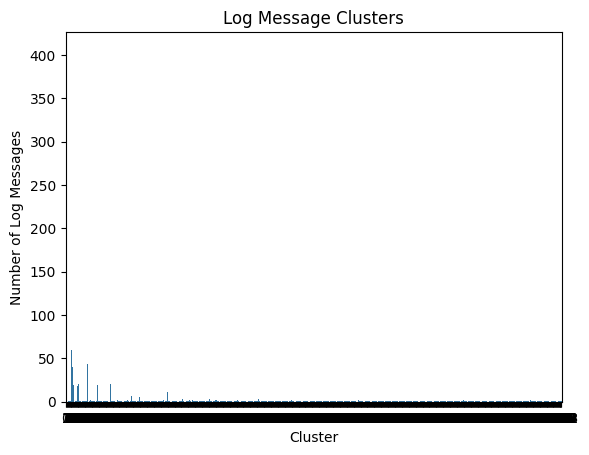

In [12]:
# # Visualize the clusters
# sns.countplot(x='cluster_label', data=df)
# plt.title('Log Message Clusters')
# plt.xlabel('Cluster')
# plt.ylabel('Number of Log Messages')
# plt.show()

In [13]:
import re
def classify_with_regex(log_message):
    regex_patterns = {
        r"User User\d+ logged (in|out).": "User Action",
        r"Backup (started|ended) at .*": "System Notification",
        r"Backup completed successfully.": "System Notification",
        r"System updated to version .*": "System Notification",
        r"File .* uploaded successfully by user .*": "System Notification",
        r"Disk cleanup completed successfully.": "System Notification",
        r"System reboot initiated by user .*": "System Notification",
        r"Account with ID .* created by .*": "User Action"
    }
    for pattern, label in regex_patterns.items():
        if re.search(pattern, log_message, re.IGNORECASE):
            return label
    return None

In [16]:
# Apply regex classification
df['regex_label'] = df['log_message'].apply(lambda x: classify_with_regex(x))
df[df['regex_label'].notnull()]

df['regex_label'].value_counts()

regex_label
System Notification    356
User Action            144
Name: count, dtype: int64

In [17]:
df_non_regex = df[df['regex_label'].isnull()].copy()
df_non_regex.shape

(1910, 7)

In [18]:
df_legacy = df_non_regex[df_non_regex.source=="LegacyCRM"]
df_legacy

,timestamp,source,log_message,target_label,complexity,cluster_label,regex_label
60,2025-10-06 16:55:23,LegacyCRM,Lead conversion failed for prospect ID 7842 du...,Workflow Error,llm,40,None
255,2025-05-03 16:55:35,LegacyCRM,API endpoint 'getCustomerDetails' is deprecate...,Deprecation Warning,llm,129,None
377,2025-06-24 12:16:29,LegacyCRM,Customer follow-up process for lead ID 5621 fa...,Workflow Error,llm,190,None
1325,2025-04-17 07:33:44,LegacyCRM,Escalation rule execution failed for ticket ID...,Workflow Error,llm,606,None
1734,2025-04-30 07:47:30,LegacyCRM,The 'ExportToCSV' feature is outdated. Please ...,Deprecation Warning,llm,778,None
1826,2025-01-23 10:33:36,LegacyCRM,Support for legacy authentication methods will...,Deprecation Warning,llm,813,None
2217,2025-05-12 09:46:54,LegacyCRM,Task assignment for TeamID 3425 could not comp...,Workflow Error,llm,986,None


In [19]:
df_non_legacy = df_non_regex[df_non_regex.source!="LegacyCRM"]
df_non_legacy

,timestamp,source,log_message,target_label,complexity,cluster_label,regex_label
0,2025-06-27 07:20:25,ModernCRM,nova.osapi_compute.wsgi.server [req-b9718cd8-f...,HTTP Status,bert,0,None
1,1/14/2025 23:07,ModernCRM,Email service experiencing issues with sending,Critical Error,bert,1,None
2,1/17/2025 1:29,AnalyticsEngine,Unauthorized access to data was attempted,Security Alert,bert,2,None
3,2025-07-12 00:24:16,ModernHR,nova.osapi_compute.wsgi.server [req-4895c258-b...,HTTP Status,bert,0,None
4,2025-06-02 18:25:23,BillingSystem,nova.osapi_compute.wsgi.server [req-ee8bc8ba-9...,HTTP Status,bert,3,None
...,...,...,...,...,...,...,...
2405,2025-08-13 07:29:25,ModernHR,nova.osapi_compute.wsgi.server [req-96c3ec98-2...,HTTP Status,bert,4,None
2406,1/11/2025 5:32,ModernHR,User 3844 account experienced multiple failed ...,Security Alert,bert,1061,None
2407,2025-08-03 03:07:47,ThirdPartyAPI,nova.metadata.wsgi.server [req-b6d4a270-accb-4...,HTTP Status,bert,172,None
2408,11/11/2025 11:52,BillingSystem,Email service affected by failed transmission,Critical Error,bert,1062,None


In [20]:
df_non_legacy.shape

(1903, 7)

In [21]:
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight embedding model
embeddings_filtered = model.encode(df_non_legacy['log_message'].tolist())

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report

X = embeddings_filtered
y = df_non_legacy['target_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
report = classification_report(y_test, y_pred)

print(report)

                precision    recall  f1-score   support

Critical Error       0.91      1.00      0.95        48
         Error       0.98      0.89      0.93        47
   HTTP Status       1.00      1.00      1.00       304
Resource Usage       1.00      1.00      1.00        49
Security Alert       1.00      0.99      1.00       123

      accuracy                           0.99       571
     macro avg       0.98      0.98      0.98       571
  weighted avg       0.99      0.99      0.99       571



In [24]:
import joblib
joblib.dump(logreg, '../models/log_classifier.joblib')

['../models/log_classifier.joblib']